### Rushil Verve Case Study Document


#### Auction Analysis for Application A

The following table contains the aggregated outcomes of several auctions that we participated in for application A. We responded with a variety of bid prices (`bid_price` column), and either won that auction or lost it (indicated via `1` or `0` in the `win` column). The `events` column shows how many times a particular response with a given outcome was observed.

##### Table 1. Aggregated Auction Statistics for Application A

| app | bid_price | win | events   |
|-----|-----------|-----|----------|
| A   | 0.01      | 0   | 100000   |
| A   | 0.01      | 1   | 0        |
| A   | 0.1       | 0   | 7000     |
| A   | 0.1       | 1   | 3000     |
| A   | 0.2       | 0   | 8000000  |
| A   | 0.2       | 1   | 2000000  |
| A   | 0.4       | 0   | 700000   |
| A   | 0.4       | 1   | 300000   |
| A   | 0.5       | 0   | 80000    |
| A   | 0.5       | 1   | 20000    |
| A   | 0.75      | 0   | 7000     |
| A   | 0.75      | 1   | 3000     |
| A   | 1         | 0   | 400      |
| A   | 1         | 1   | 600      |
| A   | 2         | 0   | 30       |
| A   | 2         | 1   | 70       |
| A   | 5         | 0   | 2        |
| A   | 5         | 1   | 8        |
| A   | 9         | 0   | 0        |
| A   | 9         | 1   | 1        |

---

#### Problem 1

Based on the table in the above scenario, estimate the expected win rate for a bid response at a given price (prices are listed in the table). State your assumptions clearly and provide the steps on how you arrived at your answer.

---

#### Problem 2

We receive money from our advertisers if we deliver them a win. Let's say that our advertiser is willing to pay \$0.50 per win. This then becomes the upper bound for the bid valuation that we can submit in response to the publisher. For example, if we submit a bid response of \$0.40 and we win, then the advertiser pays us \$0.50, we pay \$0.40 to the publisher, and we make a net revenue of \$0.10.

If our goal was to maximize net revenue, what is the most optimal bid valuation we should send in our response? Use your estimations from **Problem 1** and all other available information.

In [31]:
bidprice_data = [
{"app": "A", "bid_price": 0.01, "win": 0, "events": 100000}, 
{"app": "A", "bid_price": 0.01, "win": 1, "events": 0}, 
{"app": "A", "bid_price": 0.1, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.1, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 0.2, "win": 0, "events": 8000000}, 
{"app": "A", "bid_price": 0.2, "win": 1, "events": 2000000}, 
{"app": "A", "bid_price": 0.4, "win": 0, "events": 700000}, 
{"app": "A", "bid_price": 0.4, "win": 1, "events": 300000}, 
{"app": "A", "bid_price": 0.5, "win": 0, "events": 80000}, 
{"app": "A", "bid_price": 0.5, "win": 1, "events": 20000}, 
{"app": "A", "bid_price": 0.75, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.75, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 1, "win": 0, "events": 400}, 
{"app": "A", "bid_price": 1, "win": 1, "events": 600}, 
{"app": "A", "bid_price": 2, "win": 0, "events": 30}, 
{"app": "A", "bid_price": 2, "win": 1, "events": 70}, 
{"app": "A", "bid_price": 5, "win": 0, "events": 2}, 
{"app": "A", "bid_price": 5, "win": 1, "events": 8}, 
{"app": "A", "bid_price": 9, "win": 0, "events": 0}, 
{"app": "A", "bid_price": 9, "win": 1, "events": 1}
]

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


---

# Solution - 1

what is winRate ?

winrate = wins / total_auction 

for each bid_price our win_rate will be -

### 1.1 EDA +  Assumptions

,app,bid_price,non_win_events,win_events,auction_events,win_rate,auction_percent
0,A,0.01,100000,0,100000,0.0,0.89
1,A,0.10,7000,3000,10000,0.3,0.09
2,A,0.20,8000000,2000000,10000000,0.2,89.12
3,A,0.40,700000,300000,1000000,0.3,8.91
4,A,0.50,80000,20000,100000,0.2,0.89
5,A,0.75,7000,3000,10000,0.3,0.09
6,A,1.00,400,600,1000,0.6,0.01
7,A,2.00,30,70,100,0.7,0.00
8,A,5.00,2,8,10,0.8,0.00
9,A,9.00,0,1,1,1.0,0.00


Auction Events and win_rate distribution across bid_price
total wins: 2326679
total auction_events: 11221111
total spend : 533339.0
overall win_rate = total wins / total auction_events =  0.21


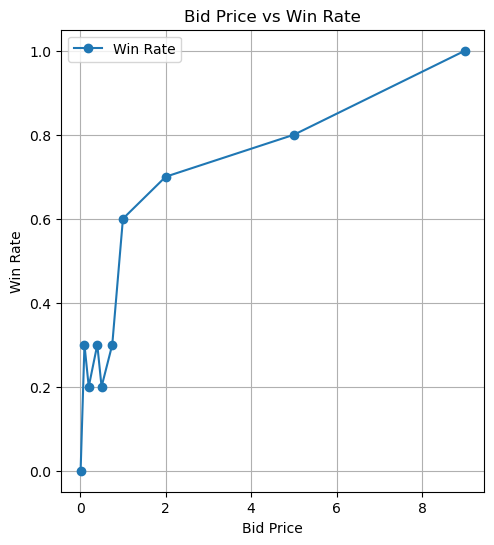

In [41]:
raw_auction_df = pd.DataFrame(bidprice_data)

raw_auction_df['win_events'] = raw_auction_df.apply(lambda x: x['events'] if x['win'] == 1 else 0, axis=1)
raw_auction_df['non_win_events'] = raw_auction_df.apply(lambda x: x['events'] if x['win'] == 0 else 0, axis=1)

# Pivot the DataFrame
auction_df = raw_auction_df.pivot_table(index=['app', 'bid_price'], values=['win_events', 'non_win_events'], aggfunc='sum').reset_index()

##total auction_events
auction_df['auction_events'] = auction_df['win_events'] + auction_df['non_win_events']

#adding win_rate
auction_df['win_rate'] = auction_df['win_events'] / (auction_df['auction_events'])

auction_df['auction_percent'] = round(auction_df['auction_events']*100 / auction_df['auction_events'].sum(),2)

display(auction_df)

print('Auction Events and win_rate distribution across bid_price')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(auction_df['bid_price'], auction_df['win_rate'], marker='o', label='Win Rate')
plt.xlabel('Bid Price')
plt.ylabel('Win Rate')
plt.title('Bid Price vs Win Rate')
plt.grid()
plt.legend()

print(f'total wins: {auction_df["win_events"].sum()}')
print(f'total auction_events: {auction_df["auction_events"].sum()}')
print(f'total spend : {(auction_df["win_events"]*auction_df["bid_price"]).sum()}')
print(f'overall win_rate = total wins / total auction_events =  {round(auction_df["win_events"].sum() / auction_df["auction_events"].sum(),2)}')

#### Assumptions

##### 1. **Data Assumption**
- Yesterday's data, where total auctions we got total spend : 533339.0, and total_auction_volume : 11221111 


##### 2. **Estimating Expected Win Rate for Given Prices**
- **Scenario**: If we only need to estimate the win rate for `bid_price` values listed in the table:
  - Use a **deterministic approach**:  
    **`win_rate = total_past_wins / total_past_auction_events`**
- **Scenario**: If we want to estimate win rates for a **range of bid prices** (including those listed in the table):
  - Use a **regression model**.

---

##### 3. **Win Rate as a Function**
- The **win rate** is a function of:
  - `bid_price`
  - `external_reason` (e.g., competition bidding, seasonality)
- **Assumption**: External reasons are constant, so the win rate is **directly dependent on bid_price**.

---

##### 4. **Here Bid Price selection is random and not Function of below**
- The `bid_price` usually depends on:
  - **Spending patterns**
  - **User signals**
  - **Contextual signals**
  - **Bid constraints**
- **Assumption**: hence, using this type of model for bid_prices selection will predetermine max auction_volume at individual bid_prices, but here selection of bid prices is random. hence, max auction_volume at individual bid_price  is unknown and can be capped at total_auction_events.

also since win_rate depends on what bid_price is set and bid_price is related to contextual signal -> this can explain the affect of win_rate to rise then dip then again rises with bid_prices.
  - **Example**:  
    - special cases like premium/private audience unlocking at specific bid prices - giving higher win_rate.
    - or scenarios where higher bid prices significantly increase total auction events.
    - **Overall total auctions and win rates flatten after a specific bid price**.

---


##### 5. **Data Limitations and Confidence**
- **Less data → Less confidence**:  
  - After a certain bid price, the number of auction events decreases.  
  - This reduces confidence in accuracy due to limited training data for validation.

---

##### 6. **Win Rate Cap**
- The **win rate** is capped at **1**.

---

##### 7. **Weighting for Bid Price Data**
- **Observation**: Bid prices like **0.2** and **0.4** account for **98% of auctions**.  
- To ensure other bid price data contributes meaningfully to the model:
  - Use **log(10) weighting** for these data points.

---

##### 8. **Non-Linear Trends in Auctions**
- **Observation**: The maximum number of auctions occurs between **0.1** and **0.85** bid prices.  
- The win rate shows a **non-linear trend**:
  - It **dips**, **rises**, **dips again**, and then **rises**.  
- To model this behavior and reduce Mean Squared Error (MSE):
  - Use a **non-linear model** like **XGBoost**.


### 1.2 Transform weights using log10

In [34]:

weights = np.log10(auction_df['auction_events'] + 1)  # Add 1 to avoid log10(0)
auction_df['log10_weights'] = weights
display(auction_df)


,app,bid_price,non_win_events,win_events,auction_events,win_rate,auction_percent,log10_weights
0,A,0.01,100000,0,100000,0.0,0.89,5.000004
1,A,0.10,7000,3000,10000,0.3,0.09,4.000043
2,A,0.20,8000000,2000000,10000000,0.2,89.12,7.000000
3,A,0.40,700000,300000,1000000,0.3,8.91,6.000000
4,A,0.50,80000,20000,100000,0.2,0.89,5.000004
5,A,0.75,7000,3000,10000,0.3,0.09,4.000043
6,A,1.00,400,600,1000,0.6,0.01,3.000434
7,A,2.00,30,70,100,0.7,0.00,2.004321
8,A,5.00,2,8,10,0.8,0.00,1.041393
9,A,9.00,0,1,1,1.0,0.00,0.301030


### 1.3 Regression Model

Mean Squared Error: 0.0002509579812699501


,app,bid_price,non_win_events,win_events,auction_events,win_rate,auction_percent,log10_weights,predicted_win_rate
0,A,0.01,100000,0,100000,0.0,0.89,5.000004,0.00
1,A,0.10,7000,3000,10000,0.3,0.09,4.000043,0.30
2,A,0.20,8000000,2000000,10000000,0.2,89.12,7.000000,0.20
3,A,0.40,700000,300000,1000000,0.3,8.91,6.000000,0.30
4,A,0.50,80000,20000,100000,0.2,0.89,5.000004,0.20
5,A,0.75,7000,3000,10000,0.3,0.09,4.000043,0.30
6,A,1.00,400,600,1000,0.6,0.01,3.000434,0.60
7,A,2.00,30,70,100,0.7,0.00,2.004321,0.70
8,A,5.00,2,8,10,0.8,0.00,1.041393,0.84
9,A,9.00,0,1,1,1.0,0.00,0.301030,0.84


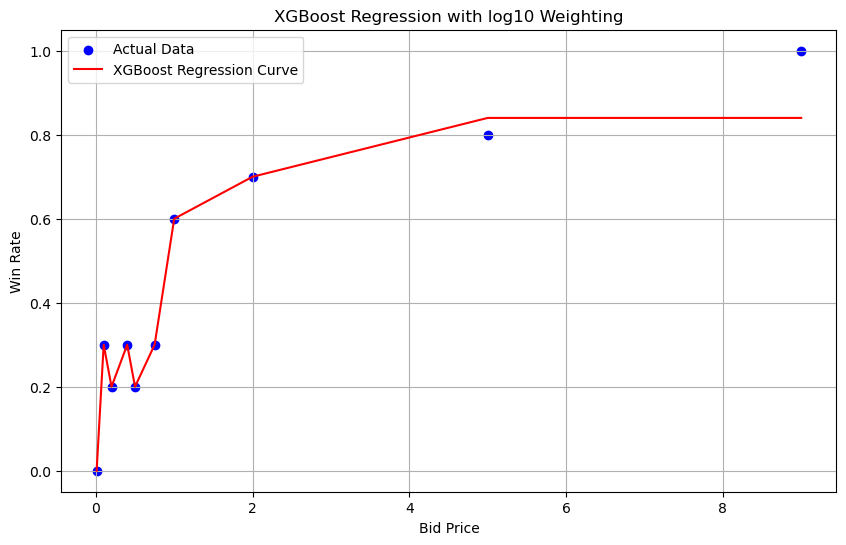

In [35]:

# XGBoost Regressor
winrate_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)

# Fit the winrate_model with transformed weights
winrate_model.fit(auction_df['bid_price'], auction_df['win_rate'], sample_weight=weights)

def get_estimated_winrate(bid_price):
    """
    Predict the win rate for a given bid price using the trained model.
    
    Parameters:
    bid_price (float): The bid price for which to predict the win rate.
    
    Returns:
    float: The predicted win rate capped at a maximum of 1, rounded to 2 decimal places.
    """
    if bid_price < 0.01:
        return 0
    prediction = winrate_model.predict([[bid_price]])[0]
    return round(min(1, prediction), 2)


auction_df['predicted_win_rate'] = auction_df['bid_price'].apply(get_estimated_winrate)

# Evaluate the winrate_model
mse = mean_squared_error(auction_df['win_rate'], auction_df['predicted_win_rate'], sample_weight=weights)
print(f"Mean Squared Error: {mse}")

# Display predictions
display(auction_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(auction_df['bid_price'], auction_df['win_rate'], color='blue', label='Actual Data')
plt.plot(auction_df['bid_price'], auction_df['predicted_win_rate'], color='red', label='XGBoost Regression Curve')
plt.xlabel('Bid Price')
plt.ylabel('Win Rate')
plt.title('XGBoost Regression with log10 Weighting')
plt.legend()
plt.grid()
plt.show()


---

# Solution - 2

### 2.1 EDA + Assumptions

In [ ]:
# drop columns not use to futher analysis
auction_df.drop(columns=['log10_weights', 'predicted_win_rate','non_win_events','auction_percent'], inplace=True)

In [37]:
advertiser_price = 0.5
auction_df['profit_margin'] = advertiser_price - auction_df['bid_price']
auction_df

,app,bid_price,win_events,auction_events,win_rate,profit_margin
0,A,0.01,0,100000,0.0,0.49
1,A,0.10,3000,10000,0.3,0.40
2,A,0.20,2000000,10000000,0.2,0.30
3,A,0.40,300000,1000000,0.3,0.10
4,A,0.50,20000,100000,0.2,0.00
5,A,0.75,3000,10000,0.3,-0.25
6,A,1.00,600,1000,0.6,-0.50
7,A,2.00,70,100,0.7,-1.50
8,A,5.00,8,10,0.8,-4.50
9,A,9.00,1,1,1.0,-8.50


In [38]:
print(' Total Auctions Events : ', auction_df['auction_events'].sum())
print(' Total Spend Happened : ', (auction_df['win_events']*auction_df['bid_price']).sum())

 Total Auctions Events :  11221111
 Total Spend Happened :  533339.0


##### Approach 1. Capping Auction Volume at each bid price to Total Auction Events but with infinite spend.

- In Solution-1 Assumption-3 we discussed that, variety of bids are placed for auctions, hence - we are not known to the maxAuction Volume from DSP at each bidPrice.
- In this scenario, we assume that the **maximum auction volume at a bid price is equal to the total auction volume across all bid prices**.  
- This assumption allows us to calculate revenue based on the total auction events and win rate for each bid price.

##### Revenue Formula:

**`revenue(bid_price) = Σ(auction_events over all bid prices) * win_rate(bid_price) * (advertiser_price - bid_price)`**

##### Why is $0.1 the best bid price?

From the table, the **total auction events across all bid prices** is:

**`Σ(auction_events) = 100,000 + 10,000 + 10,000,000 + 1,000,000 + 100,000 + 10,000 + 1,000 + 100 + 10 + 1 = 11,211,111`**

For **$0.1**, using the formula:

**`revenue(0.1) = Σ(auction_events) * win_rate(0.3) * (advertiser_price - bid_price)`**  
Assuming the advertiser price is **$0.5**, we calculate:

**`revenue(0.1) = 11,211,111 * 0.3 * (0.5 - 0.1)`**  
**`revenue(0.1) = 11,211,111 * 0.3 * 0.4 = $1,346,533`**

This matches the table value of **$1,346,533**, which is the maximum revenue achieved at **$0.1**. Other bid prices result in lower revenues due to lower win rates or higher bid prices reducing profit margins.


In [39]:
auction_df['revenue'] = (auction_df['auction_events'].sum()*auction_df['win_rate']*auction_df['profit_margin']).astype(int)
auction_df


,app,bid_price,win_events,auction_events,win_rate,profit_margin,revenue
0,A,0.01,0,100000,0.0,0.49,0
1,A,0.10,3000,10000,0.3,0.40,1346533
2,A,0.20,2000000,10000000,0.2,0.30,673266
3,A,0.40,300000,1000000,0.3,0.10,336633
4,A,0.50,20000,100000,0.2,0.00,0
5,A,0.75,3000,10000,0.3,-0.25,-841583
6,A,1.00,600,1000,0.6,-0.50,-3366333
7,A,2.00,70,100,0.7,-1.50,-11782166
8,A,5.00,8,10,0.8,-4.50,-40395999
9,A,9.00,1,1,1.0,-8.50,-95379443


##### Approach 2. Capped Spend at each bid price but with infinite auctions.

- In this scenario, we assume a **capped spend of $500**.  
- This assumption allows us to calculate the total auctions and revenue for each bid price based on the capped spend.

#### Revenue Formula:

**`total_auctions(bid_price) = capped_spend / bid_price`**  
**`revenue(bid_price) = total_auctions(bid_price) * win_rate(bid_price) * (advertiser_price - bid_price)`**  
**`revenue(bid_price) = (capped_spend / bid_price) * win_rate(bid_price) * (advertiser_price - bid_price)`**

#### Why is $0.1 the best bid price?

For **$0.1**, the total auctions are calculated as:

**`total_auctions(0.1) = capped_spend / bid_price = 500 / 0.1 = 5,000`**

Using the formula:

**`revenue(0.1) = total_auctions(5,000) * win_rate(0.3) * (advertiser_price - bid_price)`**  
Assuming the advertiser price is **$0.5**, we calculate:

**`revenue(0.1) = 5,000 * 0.3 * (0.5 - 0.1)`**  
**`revenue(0.1) = 5,000 * 0.3 * 0.4 = $600`**

This matches the table value of **$600**, which is the maximum revenue achieved at **$0.1**. Other bid prices result in lower revenues due to lower total auctions or higher bid prices reducing profit margins.


In [40]:
capped_spend = 500
auction_df['revenue'] = ((capped_spend/auction_df['bid_price'])*auction_df['win_rate']*auction_df['profit_margin']).astype(int)
auction_df


,app,bid_price,win_events,auction_events,win_rate,profit_margin,revenue
0,A,0.01,0,100000,0.0,0.49,0
1,A,0.10,3000,10000,0.3,0.40,600
2,A,0.20,2000000,10000000,0.2,0.30,150
3,A,0.40,300000,1000000,0.3,0.10,37
4,A,0.50,20000,100000,0.2,0.00,0
5,A,0.75,3000,10000,0.3,-0.25,-49
6,A,1.00,600,1000,0.6,-0.50,-150
7,A,2.00,70,100,0.7,-1.50,-262
8,A,5.00,8,10,0.8,-4.50,-360
9,A,9.00,1,1,1.0,-8.50,-472
